[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


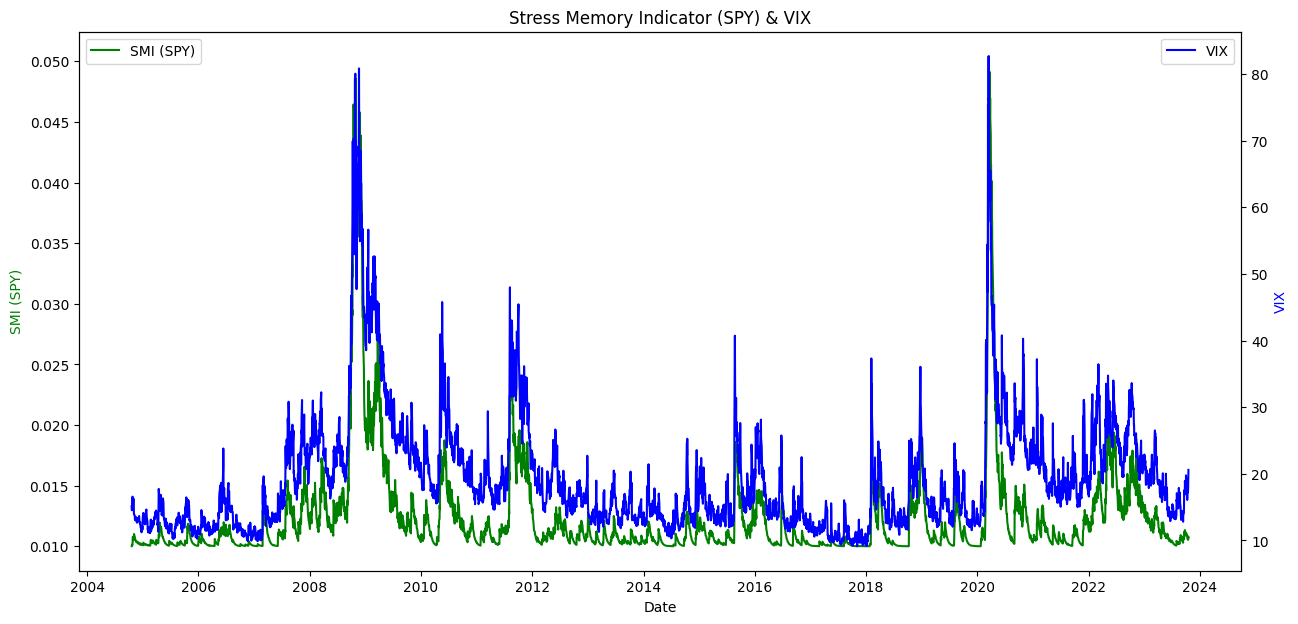

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

def fetch_data(ticker, start):
    data = yf.download(ticker, start=start)
    return data['Close']

def compute_stress_memory(data, decay_factor=0.9):
    daily_returns = data.pct_change().dropna()
    stress = np.maximum(np.abs(daily_returns), 0.01)  # Here 0.15% is considered as the base stress value
    stress_memory = [stress.iloc[0]]

    for i in range(1, len(stress)):
        sm = decay_factor * stress_memory[-1] + (1 - decay_factor) * stress.iloc[i]
        stress_memory.append(sm)

    return pd.Series(stress_memory, index=daily_returns.index)

# Fetch data
start_date = '2004-10-19'

spy_data = fetch_data('SPY', start_date)
vix_data = fetch_data('^VIX', start_date)

# Compute Stress Memory Indicator
smi = compute_stress_memory(spy_data)

# Plotting
fig, ax1 = plt.subplots(figsize=(15, 7))

ax2 = ax1.twinx()
ax1.plot(smi, 'g-', label='SMI (SPY)')
ax2.plot(vix_data, 'b-', label='VIX')

ax1.set_xlabel('Date')
ax1.set_ylabel('SMI (SPY)', color='g')
ax2.set_ylabel('VIX', color='b')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Stress Memory Indicator (SPY) & VIX')
plt.show()


Identifying options mispricing using a combination of tools like the Stress Memory Indicator (SMI) and the VIX can be approached in several ways. The underlying idea is to exploit the discrepancies between the implied volatility (reflected in options prices) and the realized or predicted volatility (estimated using tools like the SMI).

Here's a general outline of the process:

1. **Fetch Options Data**: You would first need options data, which includes strike prices, expiration dates, and the Black-Scholes implied volatilities.

2. **Calculate Realized Volatility**:
   - Using historical data of the underlying (SPY in this case), calculate the historical realized volatility. This can be a simple rolling window of standard deviation of log returns.

3. **Predict Future Volatility**:
   - Using indicators like SMI, forecast the near-term volatility. For instance, if the SMI suggests increasing stress, it could imply heightened volatility in the near future.
   - The VIX can be used as a benchmark for market's expectation of future volatility. 

4. **Compare Realized/Predicted Volatility with Implied Volatility**:
   - If the implied volatility (from options pricing) is significantly higher than the realized or SMI-predicted volatility, the option might be considered overpriced. Conversely, if it's significantly lower, the option might be underpriced.
   - It's crucial to account for other factors like events (earnings, economic announcements) which might justify the high implied volatility.

5. **Consider Other Factors**:
   - Time to expiration: Options with longer times to expiration will typically have higher implied volatilities.
   - Bid-ask spread: An option with a wide bid-ask spread might not be as liquid, making it harder to enter/exit positions.
   - Skew and term structure: Sometimes certain strike prices or expiration dates might be mispriced relative to others.

6. **Strategy Execution**:
   - If you believe an option is overpriced (high implied volatility compared to expected realized volatility), you could sell or write that option. 
   - If you believe an option is underpriced (low implied volatility compared to expected realized volatility), you could buy that option.
   - One popular strategy that takes advantage of perceived volatility discrepancies is the **volatility arbitrage strategy**.

7. **Risk Management**:
   - Options can be complex instruments with nonlinear payoffs. It's important to manage risk through hedging, setting stop losses, or using multi-leg strategies (like spreads) to limit potential losses.

It's worth noting that while tools like SMI and VIX can provide insights, there's no guarantee of predicting future volatility accurately. Also, even if an option appears mispriced, it doesn't guarantee a profit due to transaction costs, potential changes in market conditions, or other unforeseen factors.

Lastly, always backtest any strategy on historical data to see how it might have performed and to understand its risks and limitations. And, as always, consulting with a financial advisor or expert before making investment decisions is advisable.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


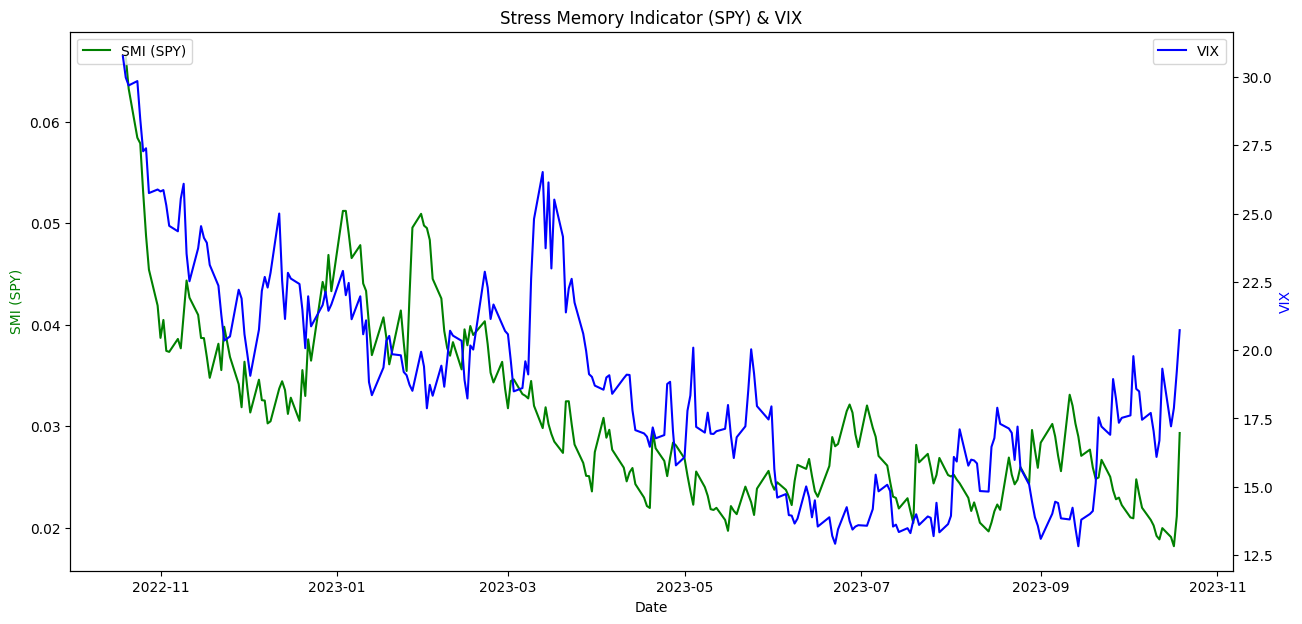

In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

def fetch_data(ticker, start):
    data = yf.download(ticker, start=start)
    return data['Close']

def compute_stress_memory(data, decay_factor=0.9):
    daily_returns = data.pct_change().dropna()
    stress = np.maximum(np.abs(daily_returns), 0.01)  # Here 0.15% is considered as the base stress value
    stress_memory = [stress.iloc[0]]

    for i in range(1, len(stress)):
        sm = decay_factor * stress_memory[-1] + (1 - decay_factor) * stress.iloc[i]
        stress_memory.append(sm)

    return pd.Series(stress_memory, index=daily_returns.index)

# Fetch data
start_date = '20-10-19'

spy_data = fetch_data('TSLA', start_date)
vix_data = fetch_data('^VIX', start_date)

# Compute Stress Memory Indicator
smi = compute_stress_memory(spy_data)

# Plotting
fig, ax1 = plt.subplots(figsize=(15, 7))

ax2 = ax1.twinx()
ax1.plot(smi, 'g-', label='SMI (SPY)')
ax2.plot(vix_data, 'b-', label='VIX')

ax1.set_xlabel('Date')
ax1.set_ylabel('SMI (SPY)', color='g')
ax2.set_ylabel('VIX', color='b')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Stress Memory Indicator (SPY) & VIX')
plt.show()


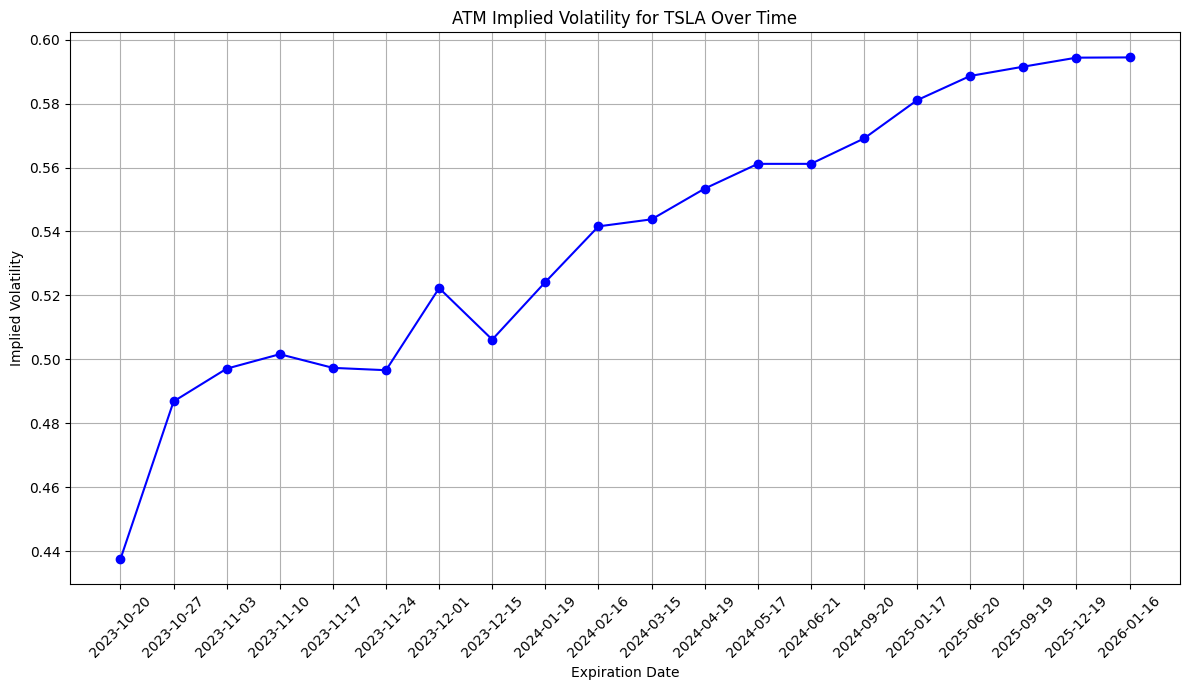

In [12]:
import yfinance as yf
import matplotlib.pyplot as plt

def get_atm_iv_over_time(ticker):
    # Fetch option data
    stock = yf.Ticker(ticker)
    last_price = stock.history(period="1d")["Close"].iloc[0]
    
    expirations = stock.options
    iv_data = []
    
    for expiration in expirations:
        option_chain = stock.option_chain(expiration)
        
        # For simplicity, we'll use call options
        calls = option_chain.calls
        
        # Find the ATM option (closest to the last stock price)
        atm_option = calls.iloc[(calls['strike'] - last_price).abs().argsort()[:1]]
        
        if not atm_option.empty:
            iv = atm_option['impliedVolatility'].values[0]
            iv_data.append((expiration, iv))
    
    return zip(*iv_data)  # returns tuple of (dates, ivs)

ticker = "TSLA"
dates, ivs = get_atm_iv_over_time(ticker)

# Plotting
plt.figure(figsize=(12, 7))
plt.plot(dates, ivs, marker='o', linestyle='-', color='b')
plt.title(f"ATM Implied Volatility for {ticker} Over Time")
plt.xlabel("Expiration Date")
plt.ylabel("Implied Volatility")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
